In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod

In [5]:
inFile  = '../EDD_distance_cf4_v27.csv'
grand_tbl   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
grand_pgc = grand_tbl['pgc']
ggl = grand_tbl['gl']
ggb = grand_tbl['gb']


inFile  = 'allTF4_pgc1_nest.csv'
allPGC1   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
PGC_all1 = allPGC1['PGC']
RA_all1 = allPGC1['RA']
DEC_all1 = allPGC1['DEC']
PGC1_all1 = allPGC1['PGC1']
Nest_all1 = allPGC1['Nest']
sglg_all1 = allPGC1['sglg']
sgbg_all1 = allPGC1['sgbg']

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [6]:
table = np.genfromtxt('DMall10736_V.spgc.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

PGC_vh = table['PGC']
Vh_vh  = table['Vh']
Vls_vh = table['Vls']
V3k_vh = table['V3k']
Vmod_vh = table['Vmod']


table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
Vhel = table['Vhel']
Vls = table['Vls']

Vmod = Vhel*0.
V3k = Vhel*0.



inFile  = '../EDD_distance_cf4_v27.csv'
grand_tbl   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
grand_pgc = grand_tbl['pgc']
ggl  = grand_tbl['gl']
ggb  = grand_tbl['gb']
ssgl = grand_tbl['sgl']
ssgb = grand_tbl['sgb']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)


ra = np.zeros(N)
dec = np.zeros(N)
pgc1 = np.zeros(N)
nest = np.zeros(N)
sglg = np.zeros(N)
sgbg = np.zeros(N)

gl  = np.zeros(N)
gb  = np.zeros(N)
sgl = np.zeros(N)
sgb = np.zeros(N)
PP= 0 
for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
        
    if idd in grand_pgc:
        indx,  = np.where(grand_pgc==idd)    
        gl[i]  = ggl[indx][0]
        gb[i]  = ggb[indx][0]  
        sgl[i] = ssgl[indx][0]
        sgb[i] = ssgb[indx][0] 
    if idd in PGC_vh:
        PP+=1
        try:
            indx,  = np.where(PGC_vh==idd) 
            Vhel[i] = Vh_vh[indx][0]
            Vls[i]  = Vls_vh[indx][0]
            V3k[i]  = V3k_vh[indx][0]
            Vmod[i]  = Vmod_vh[indx][0]
        except:
            print idd
    if idd in PGC_all1:
        try:
            indx,   = np.where(PGC_all1==idd) 
            ra[i]   = RA_all1[indx][0]
            dec[i]  = DEC_all1[indx][0]
            pgc1[i] = PGC1_all1[indx][0]
            nest[i] = Nest_all1[indx][0]
            sglg[i] = sglg_all1[indx][0]
            sgbg[i] = sgbg_all1[indx][0]
        except:
            print idd
        
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz
g_r   = ggg-rrr
r_z   = rrr-zzz

print PP

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


10736


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning

In [7]:
####################################
def TFRcurve(logW, slope, zp, A, band):


    if band in ['w1', 'w2']:
        logW0=2.4 
    else:
        logW0=2.5

    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+(zp)
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def DMcalc(logW, mag, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        dmag = 0.1
        slope=-7.03 ; zp=-19.27; Czp=-0.08; A2=6.59
        ds = 0.17 ; dzp = 0.13
    elif band=='g':
        slope=-7.37 ; zp=-20.15; Czp=-0.11; A2=4.18
        ds = 0.13 ; dzp = 0.11
    elif band=='r':
        slope=-7.96 ; zp=-20.57; Czp=-0.08; A2=4.56   
        ds = 0.13 ; dzp = 0.10
    elif band=='i':
        slope=-8.32 ; zp=-20.80; Czp=-0.04; A2=5.34
        ds = 0.13 ; dzp = 0.10
    elif band=='z':
        slope=-8.46 ; zp=-20.89; Czp=-0.08; A2=5.81 
        ds = 0.13 ; dzp = 0.10
    elif band=='w1':
        slope=-9.47 ; zp=-20.36; Czp=0.0; A2=3.81
        ds = 0.14 ; dzp = 0.07
    elif band=='w2':
        slope=-9.66 ; zp=-19.76; Czp=0.0; A2=4.42
        ds = 0.14 ; dzp = 0.07
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
###################################  
def DMcalcWc(logW, mag, i_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_i_w1 = i_w - (1.18*(logW-2.5)-0.47)
        magCorrection = -1*(-1.08*(D_i_w1)-0.04)
        mag_c = mag + magCorrection
        slope=-9.27 ; zp=-20.29; Czp=0.0; A2=0
        ds = 0.13 ; dzp = 0.10
    elif band=='w2':
        D_i_w2 = i_w - (1.32*(logW-2.5)-1.04)
        magCorrection = -1*(-1.09*(D_i_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.40 ; zp=-19.70; Czp=0.0; A2=0         
        ds = 0.14 ; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  
def DMcalcWmu(logW, mag, mu50, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_mu50_w1 = mu50 - (-4.05*(logW-2.5)+22.63)
        magCorrection = -1*(0.16*(D_mu50_w1)-0.05)
        mag_c = mag + magCorrection
        slope=-9.15 ; zp=-20.26; Czp=0.0; A2=2.55
        ds = 0.13 ; dzp = 0.07
    elif band=='w2':
        D_mu50_w2 = mu50 - (-4.06*(logW-2.5)+23.21)
        magCorrection = -1*(0.19*(D_mu50_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.18 ; zp=-19.62; Czp=0.0; A2=2.67 
        ds = 0.13 ; dzp = 0.07
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcWm21(logW, mag, m21_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_m21_w1 = m21_w - (3.27*(logW-2.5)+2.22)
        magCorrection = -1*(-0.10*(D_m21_w1))
        mag_c = mag + magCorrection
        slope=-9.12 ; zp=-20.29; Czp=0.0; A2=3.35
        ds = 0.13 ; dzp = 0.08
    elif band=='w2':
        D_m21_w2 = m21_w - (3.32*(logW-2.5)+1.65)
        magCorrection = -1*(-0.12*(D_m21_w2)-0.01)
        mag_c = mag + magCorrection
        slope=-9.22 ; zp=-19.67; Czp=0.0; A2=3.79  
        ds = 0.14; dzp = 0.08
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcOPc(logW, mag, g_i, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        u_i = g_i
        magCorrection = -1*(0.76*(u_i)-1.13)
        mag_c = mag + magCorrection
        slope=-7.88 ; zp=-19.31; Czp=-0.08; A2=5.03
        ds = 0.17; dzp = 0.13
    elif band=='g':
        magCorrection = -1*(0.73*(g_i)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.18; Czp=-0.11; A2=4.91
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_i)-0.27)
        mag_c = mag + magCorrection
        slope=-8.41 ; zp=-20.59; Czp=-0.08; A2=3.59
        ds = 0.13; dzp = 0.10
    elif band=='i':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.31*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.22 ; zp=-20.80; Czp=-0.04; A2=3.91
        ds = 0.13; dzp = 0.10
    elif band=='z':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.39*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.33 ; zp=-20.88; Czp=-0.08; A2=4.96
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################
def DMcalcOPmu(logW, mag, mu50, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='r':
        D_mu50_r = mu50 - (-2.70*(logW-2.5)+22.74)
        magCorrection = -1*(0.06*(D_mu50_r)-0.01)
        mag_c = mag + magCorrection
        slope=-7.89 ; zp=-20.55; Czp=-0.08; A2=4.34
        ds = 0.13; dzp = 0.1
    elif band=='i':
        D_mu50_i = mu50 - (-3.12*(logW-2.5)+22.48)
        magCorrection = -1*(0.06*(D_mu50_i)-0.02)
        mag_c = mag + magCorrection
        slope=-8.23 ; zp=-20.77; Czp=-0.04; A2=5.03
        ds = 0.13; dzp = 0.1
    elif band=='z':
        D_mu50_z = mu50 - (-3.45*(logW-2.5)+22.26)
        magCorrection = -1*(0.07*(D_mu50_z)-0.02)
        mag_c = mag + magCorrection
        slope=-8.35 ; zp=-20.86; Czp=-0.08; A2=3.88
        ds = 0.13; dzp = 0.07
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag_c-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
####################################

def DMcalcOPcz(logW, mag, g_z, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_z)-0.45)
        mag_c = mag + magCorrection
        slope=-7.58 ; zp=-20.16; Czp=-0.11; A2=4.74
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_z)-0.27)
        mag_c = mag + magCorrection
        slope=-8.11 ; zp=-20.57; Czp=-0.08; A2=4.98
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
 ####################################

def DMcalcOPcr(logW, mag, g_r, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_r)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.17; Czp=-0.11; A2=4.64
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_r)-0.27)
        mag_c = mag + magCorrection
        slope=-8.40 ; zp=-20.58; Czp=-0.08; A2=5.06
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM

In [8]:
def getWe_bound(err):
    
    E = [0, 0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.80]
    for i, e in enumerate(E[:-1]):
        
        if err==e:
            return np.asarray([e,e])
        
        if err>e and err<E[i+1]:
            return np.asarray([e, E[i+1]])
    
    if err==E[i+1]:
        return np.asarray([E[i+1], E[i+1]])
    else: return None     
  
###############################

def getW_bound(logWimx):
    
    W = np.arange(1,3.1,0.1)
    N = len(W)
    for i in range(N-1):
        
        if logWimx==W[i]:
            return np.asarray([logWimx, logWimx])
        
        if logWimx>W[i] and logWimx<W[i+1]:
            return np.asarray([W[i], W[i+1]])
    
    if logWimx==W[i+1]:
        return np.asarray([W[i+1], W[i+1]])
    else: return None   
    

def intepBias(df, logWimx, err):
    
    Ebound = getWe_bound(err)
    Wbound = getW_bound(logWimx)
    i_Wbound = (Wbound-1)/0.1
    
    
    if err>0.4:
        Ebound = np.asarray([0.2, 0.4])
        
        e00 = df['%.2F'%Ebound[0]][int(i_Wbound[0])]
        if e00<0: e00=0
        e01 = df['%.2F'%Ebound[1]][int(i_Wbound[0])]
        if e01<0: e01=0
        e10 = df['%.2F'%Ebound[0]][int(i_Wbound[1])]
        if e10<0: e10=0
        e11 = df['%.2F'%Ebound[1]][int(i_Wbound[1])]
        if e11<0: e11=0
        
        e20 = (e10-e00)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e00
        e40 = (e11-e01)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e01
        
        Bias = (err-0.40)*(e40-e20)/0.2+e40
        if Bias<0: Bias = 0 
        
        return Bias
    
    
    sum_w = 0
    sum_e = 0
    for i in [0,1]:
        for j in [0,1]:
            e = df['%.2F'%Ebound[i]][int(i_Wbound[j])]
            dist2 = (logWimx-Wbound[j])**2 + (err-Ebound[i])**2 + 1.E-10
            weight = 1./dist2
            sum_e += e*weight
            sum_w += weight
    Bias = sum_e/sum_w 
    if Bias<0: Bias = 0 
        
    return Bias





In [9]:
def intepBias_list(fname, logWimx, logWimx_e):
    
    df = pd.read_csv('fieldGals_simul/'+fname+'.csv', header=0, dtype=np.float64, names=["logWimx", "0.01", "0.01_err", "0.02", "0.02_err", "0.05", "0.05_err", "0.10", "0.10_err", "0.20", "0.20_err", "0.40", "0.40_err", "0.80", "0.80_err"])
    df['0.00'] = 0

    
    
    Bias = logWimx*0.
    N = len(logWimx)
    
    for i in range(N):
        Bias[i] = intepBias(df, logWimx[i], logWimx_e[i])
    
    return Bias

In [10]:
Bias_u = intepBias_list('DMcalc_u', logWimx, logWimx_e)
Bias_g = intepBias_list('DMcalc_g', logWimx, logWimx_e)
Bias_r = intepBias_list('DMcalc_r', logWimx, logWimx_e)
Bias_i = intepBias_list('DMcalc_i', logWimx, logWimx_e)
Bias_z = intepBias_list('DMcalc_z', logWimx, logWimx_e)

BiasOPc_u = intepBias_list('DMcalcOPc_u', logWimx, logWimx_e)
BiasOPc_g = intepBias_list('DMcalcOPc_g', logWimx, logWimx_e)
BiasOPc_r = intepBias_list('DMcalcOPc_r', logWimx, logWimx_e)
BiasOPc_i = intepBias_list('DMcalcOPc_i', logWimx, logWimx_e)
BiasOPc_z = intepBias_list('DMcalcOPc_z', logWimx, logWimx_e)

BiasWc_w1 = intepBias_list('DMcalcWc_w1', logWimx, logWimx_e)
BiasWc_w2 = intepBias_list('DMcalcWc_w2', logWimx, logWimx_e)

BiasWmu_w1 = intepBias_list('DMcalcWmu_w1', logWimx, logWimx_e)
BiasWmu_w2 = intepBias_list('DMcalcWmu_w2', logWimx, logWimx_e)

BiasWm21_w1 = intepBias_list('DMcalcWm21_w1', logWimx, logWimx_e)
BiasWm21_w2 = intepBias_list('DMcalcWm21_w2', logWimx, logWimx_e)

BiasOPmu_r = intepBias_list('DMcalcOPmu_r', logWimx, logWimx_e)
BiasOPmu_i = intepBias_list('DMcalcOPmu_i', logWimx, logWimx_e)
BiasOPmu_z = intepBias_list('DMcalcOPmu_z', logWimx, logWimx_e)

BiasOPcz_g = intepBias_list('DMcalcOPcz_g', logWimx, logWimx_e)
BiasOPcz_r = intepBias_list('DMcalcOPcz_r', logWimx, logWimx_e)

BiasOPcr_g = intepBias_list('DMcalcOPcr_g', logWimx, logWimx_e)
BiasOPcr_r = intepBias_list('DMcalcOPcr_r', logWimx, logWimx_e)

In [11]:
DM_u, dDM_u = DMcalc(logWimx, uuu, band='u', deltaDM=0, dlogW=logWimx_e)
DM_g, dDM_g = DMcalc(logWimx, ggg, band='g', deltaDM=0, dlogW=logWimx_e)
DM_r, dDM_r = DMcalc(logWimx, rrr, band='r', deltaDM=0, dlogW=logWimx_e)
DM_i, dDM_i = DMcalc(logWimx, iii, band='i', deltaDM=0, dlogW=logWimx_e)
DM_z, dDM_z = DMcalc(logWimx, zzz, band='z', deltaDM=0, dlogW=logWimx_e)

DM_1, dDM_1 = DMcalc(logWimx, w11, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2, dDM_2 = DMcalc(logWimx, w22, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1c, dDM_1c = DMcalcWc(logWimx, w11, i_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2c, dDM_2c = DMcalcWc(logWimx, w22, i_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1mu, dDM_1mu = DMcalcWmu(logWimx, w11, mu50_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2mu, dDM_2mu = DMcalcWmu(logWimx, w22, mu50_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1m21, dDM_1m21 =  DMcalcWm21(logWimx, w11, m21_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2m21, dDM_2m21 =  DMcalcWm21(logWimx, w22, m21_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_uc, dDM_uc = DMcalcOPc(logWimx, uuu, u_i, band='u', deltaDM=0, dlogW=logWimx_e)
DM_gc, dDM_gc = DMcalcOPc(logWimx, ggg, g_i, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rc, dDM_rc = DMcalcOPc(logWimx, rrr, g_i, band='r', deltaDM=0, dlogW=logWimx_e)
DM_ic, dDM_ic = DMcalcOPc(logWimx, iii, g_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zc, dDM_zc = DMcalcOPc(logWimx, zzz, g_i, band='z', deltaDM=0, dlogW=logWimx_e)

DM_rmu, dDM_rmu = DMcalcOPmu(logWimx, rrr, mu50_r, band='r', deltaDM=0, dlogW=logWimx_e)
DM_imu, dDM_imu = DMcalcOPmu(logWimx, iii, mu50_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zmu, dDM_zmu = DMcalcOPmu(logWimx, zzz, mu50_z, band='z', deltaDM=0, dlogW=logWimx_e)

DM_gcz, dDM_gcz = DMcalcOPcz(logWimx, ggg, g_z, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcz, dDM_rcz = DMcalcOPcz(logWimx, rrr, g_z, band='r', deltaDM=0, dlogW=logWimx_e)

DM_gcr, dDM_gcr = DMcalcOPcr(logWimx, ggg, g_r, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcr, dDM_rcr = DMcalcOPcr(logWimx, rrr, g_r, band='r', deltaDM=0, dlogW=logWimx_e)

In [12]:
def Malmquist(DM, FIT):
    
    a = FIT[0]
    b = FIT[1]
    c = FIT[2]
    d = FIT[3]
    
    DM0 = 31
    X = DM-DM0
    if DM<DM0:
        return 0
    return a*X**4+b*X**3+c*X**2+d*X

def Malmquist_list(DM_list, FIT):

    bias = DM_list*0
    for i, dm in enumerate(DM_list):
        bias[i] = Malmquist(dm, FIT)
        
    
    return bias

###############################################

DM_Bias_g = Malmquist_list(DM_g, [ 0.00070339, -0.0041936,   0.00938176,  0.01166093])
DM_Bias_r = Malmquist_list(DM_r, [ 0.00072797, -0.00579983,  0.01476469,  0.00441849])
DM_Bias_i = Malmquist_list(DM_i, [ 0.00059188, -0.00390944,  0.00905594,  0.00808488])
DM_Bias_z = Malmquist_list(DM_z, [ 0.00063983, -0.00432873,  0.00977446,  0.00877426])
DM_Bias_w1 = Malmquist_list(DM_1, [ 0.00047361, -0.00347111,  0.0100281,   0.00781361])
DM_Bias_w2 = Malmquist_list(DM_2, [ 0.00063753, -0.00428832,  0.00958391,  0.00901858])

DM_BiasOPc_g = Malmquist_list(DM_gc, [0.0003003,  0.0005683,  0.00036072, 0.01809624])
DM_BiasOPc_r = Malmquist_list(DM_rc, [ 0.00030416, -0.00065773,  0.00437926,  0.01003333])
DM_BiasOPc_i = Malmquist_list(DM_ic, [ 0.00025896, -0.00019396,  0.00251409,  0.01097701])
DM_BiasOPc_z = Malmquist_list(DM_zc, [ 0.00031969, -0.00086671,  0.00394011,  0.01034655])

DM_BiasWc_w1 = Malmquist_list(DM_1c, [ 0.00063623, -0.00427394,  0.00953633,  0.00906471])
DM_BiasWc_w2 = Malmquist_list(DM_2c, [ 0.00013239, -0.00068404,  0.00301664,  0.00260721])

DM_BiasWmu_w1 = Malmquist_list(DM_1mu, [ 9.85763880e-05, -4.85477753e-04,  2.33076618e-03,  2.53235926e-03])
DM_BiasWmu_w2 = Malmquist_list(DM_2mu, [ 5.36884602e-05, -5.16518138e-03,  1.66036108e-01, -1.78286186e+00])

DM_BiasWm21_w1 = Malmquist_list(DM_1m21, [ 0.00028377, -0.00101376,  0.00403425,  0.00890308])
DM_BiasWm21_w2 = Malmquist_list(DM_2m21, [ 0.00031174, -0.00124993,  0.00509513,  0.00927144])

DM_BiasOPmu_r = Malmquist_list(DM_rmu, [ 0.00030274, -0.00064176,  0.00432602,  0.01008105])
DM_BiasOPmu_i = Malmquist_list(DM_imu, [ 0.00025983, -0.00019724,  0.00251187,  0.01098619])
DM_BiasOPmu_z = Malmquist_list(DM_zmu, [ 0.00031944, -0.00086424,  0.00393372,  0.01035059])

DM_BiasOPcz_g = Malmquist_list(DM_gcz, [0.0003052,  0.00054022, 0.00037926, 0.01817822])
DM_BiasOPcz_r = Malmquist_list(DM_rcz, [ 0.00030361, -0.00064991,  0.00435154,  0.01005489])

DM_BiasOPcr_g = Malmquist_list(DM_gcr, [0.00029795, 0.00059566, 0.00025408, 0.01825547])
DM_BiasOPcr_r = Malmquist_list(DM_rcr, [ 0.00030489, -0.00066569,  0.00440376,  0.01001611])

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [13]:
def lineF(x, a, b):
    return a*x+b


In [14]:
def rrmmss(delta):
    

    
    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N))
    
    return rms

In [64]:
def adjustDM(DM1, dDMo, DM2, dDM_i, COLindex, xlim=(-2,2), ylim=(-0.9,0.9), 
             quad=False, indx=None, xlabel='', ylabel='', bias1=0, bias2=0, single=False):
    
    DMo  = DM1 + bias1
    DM_i = DM2 + bias2
    
    fig = py.figure(figsize=(12, 4), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    ax1 = plt.subplot(gs[0])
    if not single:
        ax2 = plt.subplot(gs[1])
    from matplotlib.ticker import MultipleLocator
    ax1.yaxis.set_major_locator(MultipleLocator(0.5))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
    if not single:
        ax2.yaxis.set_major_locator(MultipleLocator(0.5))
        ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
    _, y_ax =  set_axes(ax1, xlim, ylim, fontsize=14)
    y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
    y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    if not single:
        _, y_ax =  set_axes(ax2, xlim, ylim, fontsize=14)
        y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
        y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))    
    dDM =  DMo - DM_i 
    dDM_e = np.sqrt(dDMo**2+dDM_i**2)
    
    v = np.linspace(xlim[0]+0.1, xlim[1]-0.1,200)
        
    if indx is None:
        indx = np.arange(len(dDM))
    
    ax1.plot(COLindex[indx], dDM[indx], '.', alpha=0.05, color='k')    
    
    if not quad:
        fit, cov = curve_fit(lineF, COLindex[indx], dDM[indx], sigma=dDM_e[indx])
        correction = (fit[0]*COLindex+fit[1])
        if not single:
            ax1.plot(v,fit[0]*v+fit[1], 'r--')
    else:
        fit, cov = np.polyfit(COLindex[indx], dDM[indx], 2, cov=True, w=1./dDM_e[indx])
        correction = (fit[0]*COLindex**2+fit[1]*COLindex+fit[2])
        if not single:
            ax1.plot(v,fit[0]*v**2+fit[1]*v+fit[2], 'r--')
    
    print "Fit params:"
    for i in range(len(fit)):
        print '%.3f'%fit[i]+'\pm'+'%.3f'%np.sqrt(cov[i][i])
    
    dDM_mod = dDM - correction
    if not single:
        ax2.plot(COLindex[indx], dDM_mod[indx], '.', alpha=0.05)
    

    ##############################
    X = COLindex[indx]
    Y = dDM_mod[indx]
    Y0 = dDM[indx]
    Ye = dDM_e[indx]
    for i in np.arange(xlim[0]+0.1, xlim[1]-0.1,0.2):
        xp = []
        yp = []
        yp0 = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+0.2:
                xp.append(xi)
                yp.append(Y[ii])
                yp0.append(Y0[ii])
        if len(xp)>0:
            if not single:
                ax2.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6)     
            ax1.errorbar(np.median(xp), np.median(yp0), yerr=np.std(yp0), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6)   
    ###############################    
    ax1.plot([-10,10], [0,0], 'k:')
    if not single:
        ax2.plot([-10,10], [0,0], 'k:')
    ###############################
    c = np.polyfit(X,Y, 2, w=1./Ye)
    ###############################
    
    if not single:
        Ylm = ax2.get_ylim() ; Xlm = ax2.get_xlim()
        x0 = 0.9*Xlm[0]+0.1*Xlm[1]
        y0 = 0.9*Ylm[0]+0.10*Ylm[1]
        RMS = np.std(Y)
        ax2.text(x0,y0, r"$RMS$" +": %.2f [mag]" % RMS, fontsize=16, color='k')    
        x0 = 0.13*Xlm[0]+0.87*Xlm[1]
        ax2.errorbar(x0, [-0.5], yerr=np.median(dDM_e),xerr=0.05*1.414, fmt='.', color='green', capsize=3)
    
    ax1.set_xlabel(xlabel, fontsize=18) 
    ax1.set_ylabel(r'$'+ylabel+'- DM_{z}$', fontsize=18) 
    if not single:
        ax2.set_xlabel(xlabel, fontsize=18) 
        ax2.set_ylabel(r'$C('+ylabel+') - DM_{z}$', fontsize=18) 
    

    
    plt.subplots_adjust(hspace=.0, wspace=0.25)
    
    if single:
        ax2=None
    
    return [ax1,ax2], DMo-correction, fit, cov
    
###############################    ###############################



In [65]:
print len(ggg)

10736


In [66]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']

keep = pgc_tab*0.

p = 0
for i, idd in enumerate(pgc_tab):
    
    if not idd in pgc_drop:
        
        keep[i] = 1
    else:
        p+=1

        
print p

473


In [67]:
P0 = table['P0_w2']
P0p = table['P0_w2p']

RS = table['R_source']

indx, = np.where(RS==0)  ## sdss only
print len(indx)
for ix in indx:
    P0[ix]=P0p[ix]

5395


Fit params:
-0.670\pm0.009
-0.462\pm0.006
Fit params:
-0.003\pm0.001
-0.074\pm0.003
-0.048\pm0.005
Fit params:
-0.002\pm0.088
0.271\pm0.429
-0.660\pm0.521
Fit params:
-0.010\pm0.001
0.490\pm0.057
-6.114\pm0.663
Fit params:
-0.281\pm0.012
-0.176\pm0.008


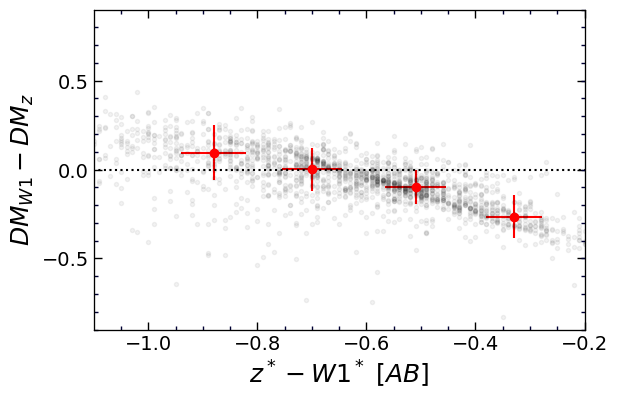

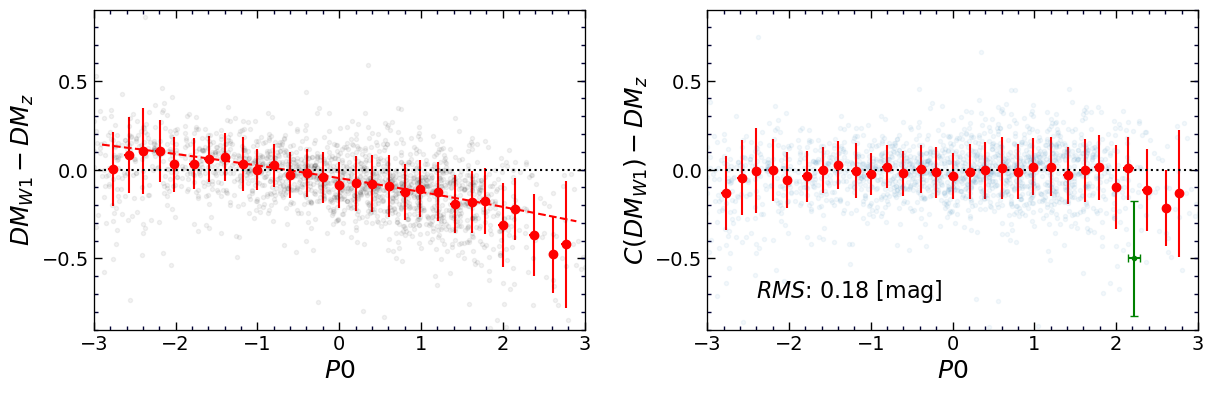

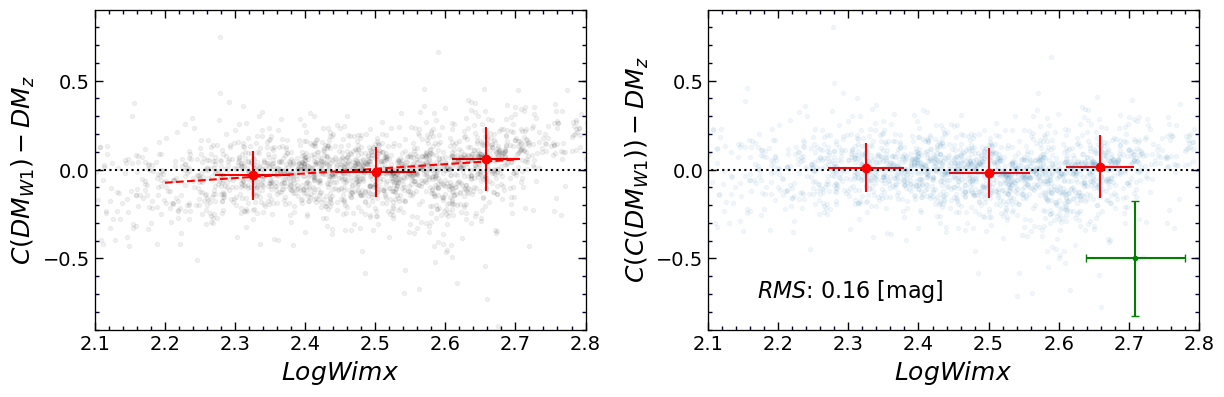

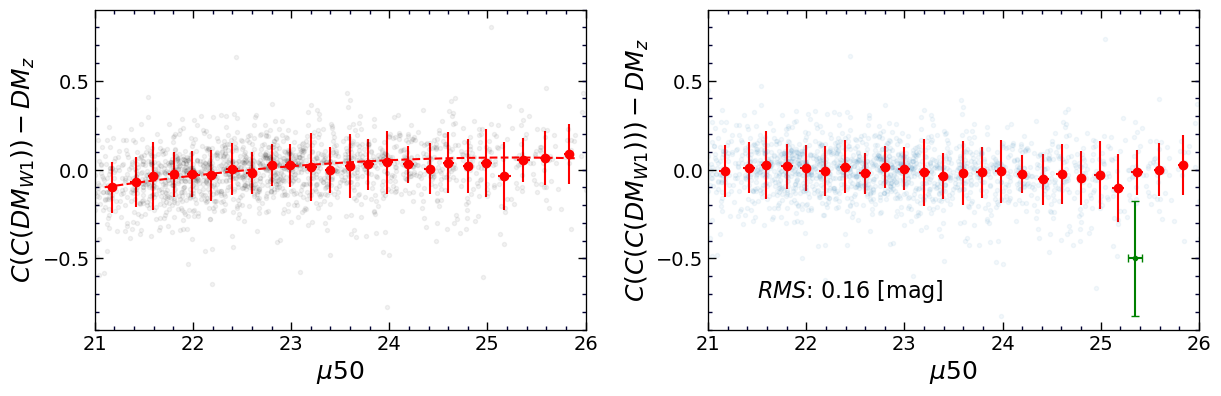

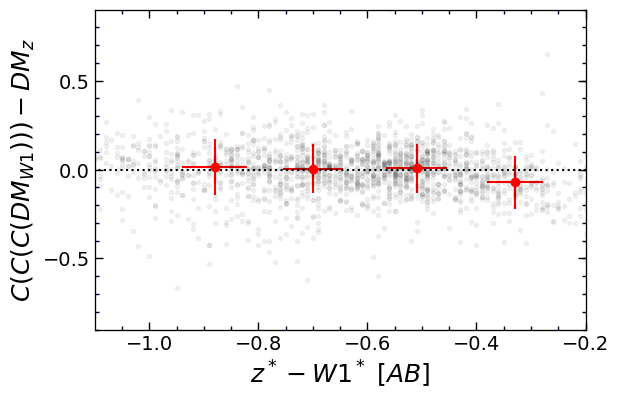

In [68]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1) & (WWqlt>3) & (w22>0) & (w11>0) & (RS==2))


axes, _, fit, cov = adjustDM(DM_1, dDM_1 , DM_z, dDM_z, zzz-w11, 
                        xlim=(-1.1,-0.2), indx=indx, quad=False, single=True,
                        xlabel=r'$z^*-W1^* \/\/ [AB]$', 
                        ylabel='DM_{W1}', 
                        bias1 = DM_Bias_w1,
                        bias2 = DM_Bias_z
                        )



axes, DM1, fit, cov = adjustDM(DM_1, dDM_1, DM_z, dDM_z, P0, 
                        xlim=(-3,3), indx=indx, quad=True,
                        xlabel=r'$P0$', 
                        ylabel='DM_{W1}', 
                        bias1 = DM_Bias_w1,
                        bias2 = DM_Bias_z
                        )

axes, DM1, fit, cov = adjustDM(DM1, dDM_1, DM_z, dDM_z, logWimx, 
                        xlim=(2.1,2.8), indx=indx, quad=True,
                        xlabel=r'$LogWimx$', 
                        ylabel='C(DM_{W1})', 
                        bias2 = DM_Bias_z
                        )


axes, DM1, fit, cov = adjustDM(DM1, dDM_1, DM_z, dDM_z, mu50_w1, 
                        xlim=(21,26), indx=indx, quad=True,
                        xlabel=r'$\mu50$', 
                        ylabel='C(C(DM_{W1}))', 
                        bias2 = DM_Bias_z
                        )



axes, _, fit, cov = adjustDM(DM1, dDM_1, DM_z, dDM_z, zzz-w11, 
                        xlim=(-1.1,-0.2), indx=indx, quad=False, single=True,
                        xlabel=r'$z^*-W1^* \/\/ [AB]$', 
                        ylabel='C(C(C(DM_{W1})))', 
                        bias2 = DM_Bias_z
                        )

Fit params:
-0.370\pm0.013
-0.366\pm0.009
Fit params:
0.001\pm0.001
-0.012\pm0.003
-0.138\pm0.005
Fit params:
0.315\pm0.092
-1.733\pm0.447
2.352\pm0.542
Fit params:
-0.013\pm0.001
0.562\pm0.062
-6.227\pm0.738
Fit params:
-0.365\pm0.011
-0.228\pm0.008


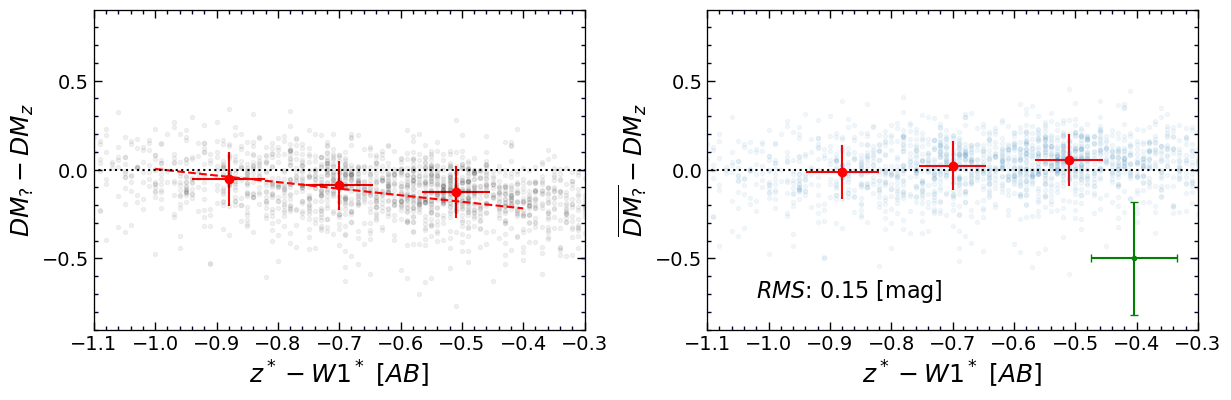

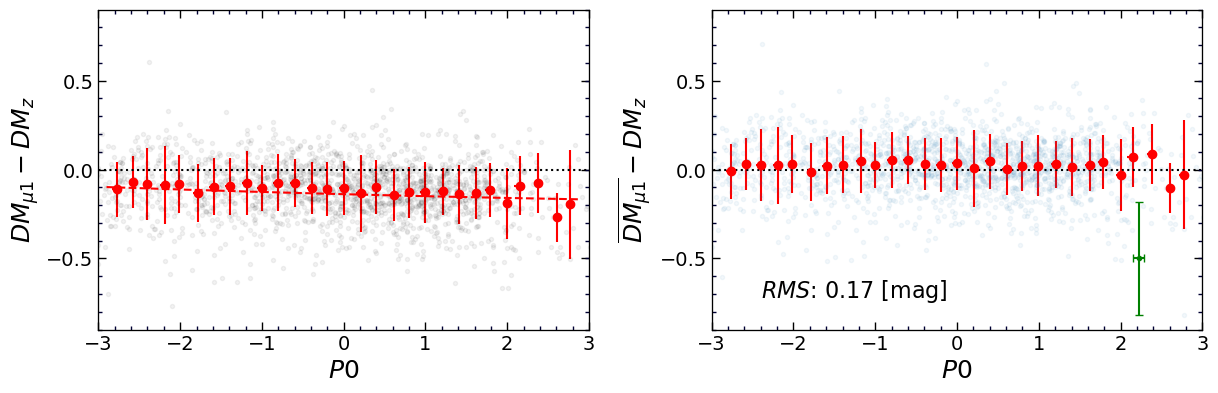

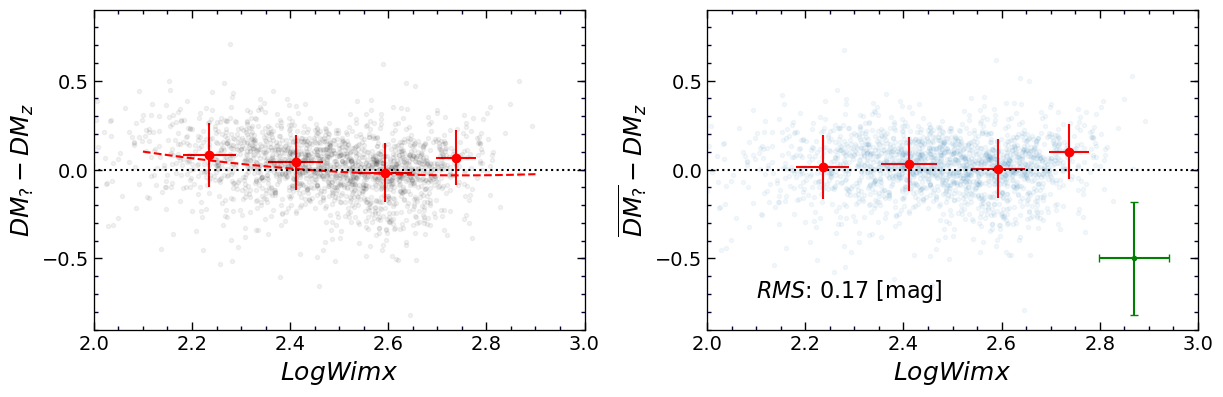

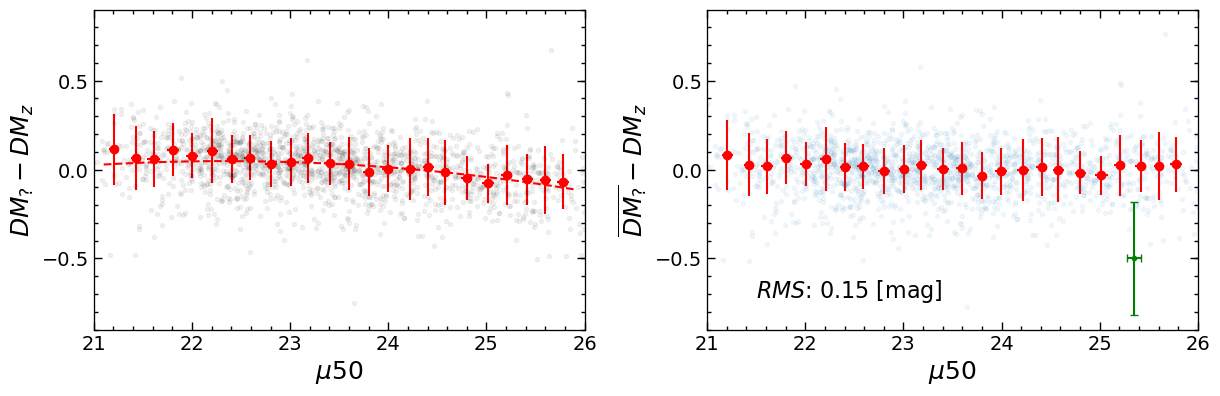

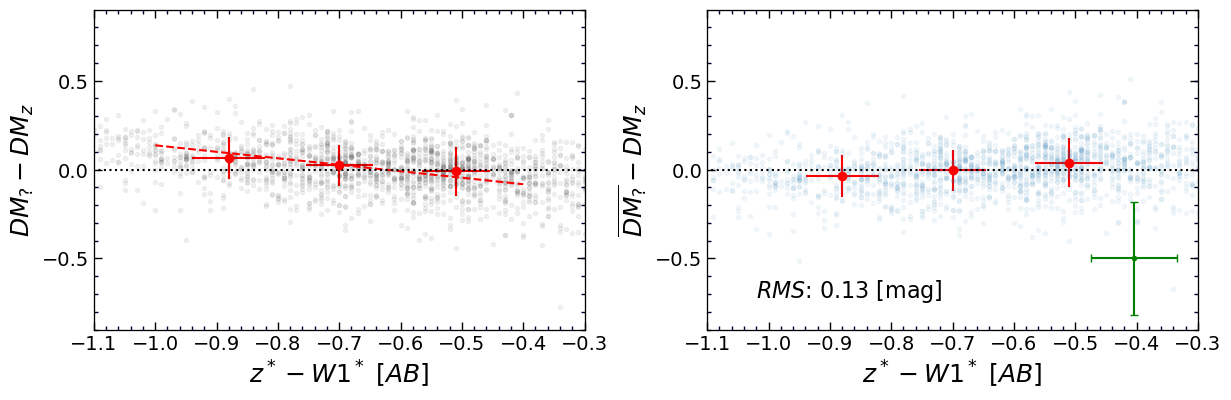

In [39]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1) & (WWqlt>3) & (w22>0) & (w11>0) & (RS==2))


axes, _, fit, cov = adjustDM(DM_1mu, dDM_1mu , DM_z, dDM_z, zzz-w11, 
                        xlim=(-1.1,-0.3), indx=indx, quad=False,
                        xlabel=r'$z^*-W1^* \/\/ [AB]$', 
                        ylabel='DM_{?}', 
                        bias1 = DM_BiasWmu_w1,
                        bias2 = DM_Bias_z
                        )



axes, DM1, fit, cov = adjustDM(DM_1mu, dDM_1mu, DM_z, dDM_z, P0, 
                        xlim=(-3,3), indx=indx, quad=True,
                        xlabel=r'$P0$', 
                        ylabel='DM_{\mu1}', 
                        bias1 = DM_BiasWmu_w1,
                        bias2 = DM_Bias_z
                        )

axes, DM1, fit, cov = adjustDM(DM1, dDM_1mu, DM_z, dDM_z, logWimx, 
                        xlim=(2,3), indx=indx, quad=True,
                        xlabel=r'$LogWimx$', 
                        ylabel='DM_{?}', 
                        bias2 = DM_Bias_z
                        )


axes, DM1, fit, cov = adjustDM(DM1, dDM_1mu, DM_z, dDM_z, mu50_w2, 
                        xlim=(21,26), indx=indx, quad=True,
                        xlabel=r'$\mu50$', 
                        ylabel='DM_{?}', 
                        bias2 = DM_Bias_z
                        )



axes, _, fit, cov = adjustDM(DM1, dDM_1mu, DM_z, dDM_z, zzz-w11, 
                        xlim=(-1.1,-0.3), indx=indx, quad=False,
                        xlabel=r'$z^*-W1^* \/\/ [AB]$', 
                        ylabel='DM_{?}', 
                        bias2 = DM_Bias_z
                        )